#notebook setup

In [1]:
!pip install google-auth --upgrade
!pip install grpcio --upgrade

Requirement already up-to-date: google-auth in /usr/local/lib/python3.6/dist-packages (1.10.0)
Requirement already up-to-date: grpcio in /usr/local/lib/python3.6/dist-packages (1.26.0)


In [0]:
!pip install -qq tf-nightly-gpu-2.0-preview

In [3]:
import tensorflow as tf
print(tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.0.0-dev20191002
Found GPU at: /device:GPU:0


In [0]:
import sys
try:
    import ujson as json
except ImportError:
    try:
        import simplejson as json
    except ImportError:
        import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.preprocessing import MinMaxScaler
import pywt
import os
from PIL import Image
# import tensorflow as tf
from glob import glob

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model,load_model,Sequential

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

def plot_hist(input_history, filename):
  # summarize history for accuracy
  fig, ax = plt.subplots(1,2)
  plt.subplots_adjust(right=2)
  ax[1].plot(input_history.history['accuracy'])
  ax[1].plot(input_history.history['val_accuracy'])
  ax[1].set_title('model accuracy')
  ax[1].set_ylabel('accuracy')
  ax[1].set_xlabel('epoch')
  ax[1].legend(['train', 'test'], loc='upper left')

  # summarize history for loss
  ax[0].plot(input_history.history['loss'])
  ax[0].plot(input_history.history['val_loss'])
  ax[0].set_title('model loss')
  ax[0].set_ylabel('loss')
  ax[0].set_xlabel('epoch')
  ax[0].legend(['train', 'test'], loc='upper left')
  plt.savefig(cwd+'/model_performance/' + filename + '.jpg')

# Data prep

In [6]:
%cd drive/'My Drive/lhc_durham'
!pwd

/content/drive/My Drive/lhc_durham
/content/drive/My Drive/lhc_durham


In [7]:
img_folder = '/filtered_images'
!ls 'filtered_images'

0  1  2


class 0 : DYjets
class 1 : TTjets
class 2 : Wjets

## Train val size setting

In [10]:
cwd = os.getcwd()
img_path = cwd + img_folder

train_val_size = 1200

df = {}
data = []
for idx, x in enumerate(os.listdir(img_path)):
  if x.isdigit() and idx < 3:
    for idx2, pic in enumerate(os.listdir(img_path+'/'+str(x))):
      if idx2 < train_val_size:
        data.append((img_path+ '/' + x + '/' + pic , x))

df = pd.DataFrame(data, columns=['filename', 'class'])
df['class'] = df['class'].astype(int)
#shuffle
df = df.sample(frac=1).reset_index(drop=True)

print(df.head())
print(len(df))
df.dtypes

                                            filename  class
0  /content/drive/My Drive/lhc_durham/filtered_im...      2
1  /content/drive/My Drive/lhc_durham/filtered_im...      1
2  /content/drive/My Drive/lhc_durham/filtered_im...      0
3  /content/drive/My Drive/lhc_durham/filtered_im...      2
4  /content/drive/My Drive/lhc_durham/filtered_im...      2
3600


filename    object
class        int64
dtype: object

In [11]:
from collections import Counter
cnt = Counter(df['class'])
cnt

Counter({0: 1200, 1: 1200, 2: 1200})

In [12]:
# Split into train and validation sets
train_percentage = .8
val_percentage = 0.1
test_percentage = 0.1

train_length = int(len(df) * train_percentage)
df_train = df[:train_length]

val_length = int(len(df) * val_percentage)
df_val = df[train_length : train_length+val_length]

test_length = int(len(df) * test_percentage)
df_test = df[ train_length + val_length : ]

# shuffle 
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

df_list = [df_train, df_val, df_test]
for df_part in df_list:
  print(len(df_part))

2880
360
360


#### image parsing

In [0]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 200,200
num_classes = len(set(df['class']))
batch_size = 120

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  image_resized = tf.ensure_shape(image_resized ,shape=(img_rows, img_cols,3))
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_train['filename'].values, tf.string),
                                                    tf.cast(df_train['class'].values, tf.int32) ))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [0]:
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.shuffle(5000)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

In [0]:
test_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_test['filename'].values, tf.string),
                                                    tf.cast(df_test['class'].values, tf.int32) ))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.shuffle(5000)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

In [18]:
train_dataset

<BatchDataset shapes: ((120, 200, 200, 3), (120, 3)), types: (tf.float32, tf.float32)>

# InceptionV3

## Entirely frozen

In [0]:
base_incepv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(200, 200, 3),pooling=None)

In [0]:
# add a global spatial average pooling layer
x = base_incepv3.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

In [0]:
# this is the model we will train
base_incepv3_model = Model(inputs=base_incepv3.input, outputs=predictions)

In [36]:
for layer in base_incepv3.layers:
    print(layer.name)
    layer.trainable = False

input_3
conv2d_188
batch_normalization_188
activation_188
conv2d_189
batch_normalization_189
activation_189
conv2d_190
batch_normalization_190
activation_190
max_pooling2d_8
conv2d_191
batch_normalization_191
activation_191
conv2d_192
batch_normalization_192
activation_192
max_pooling2d_9
conv2d_196
batch_normalization_196
activation_196
conv2d_194
conv2d_197
batch_normalization_194
batch_normalization_197
activation_194
activation_197
average_pooling2d_18
conv2d_193
conv2d_195
conv2d_198
conv2d_199
batch_normalization_193
batch_normalization_195
batch_normalization_198
batch_normalization_199
activation_193
activation_195
activation_198
activation_199
mixed0
conv2d_203
batch_normalization_203
activation_203
conv2d_201
conv2d_204
batch_normalization_201
batch_normalization_204
activation_201
activation_204
average_pooling2d_19
conv2d_200
conv2d_202
conv2d_205
conv2d_206
batch_normalization_200
batch_normalization_202
batch_normalization_205
batch_normalization_206
activation_200
activa

In [37]:
for layer in base_incepv3_model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_3  Trainable = False
conv2d_188  Trainable = False
batch_normalization_188  Trainable = False
activation_188  Trainable = False
conv2d_189  Trainable = False
batch_normalization_189  Trainable = False
activation_189  Trainable = False
conv2d_190  Trainable = False
batch_normalization_190  Trainable = False
activation_190  Trainable = False
max_pooling2d_8  Trainable = False
conv2d_191  Trainable = False
batch_normalization_191  Trainable = False
activation_191  Trainable = False
conv2d_192  Trainable = False
batch_normalization_192  Trainable = False
activation_192  Trainable = False
max_pooling2d_9  Trainable = False
conv2d_196  Trainable = False
batch_normalization_196  Trainable = False
activation_196  Trainable = False
conv2d_194  Trainable = False
conv2d_197  Trainable = False
batch_normalization_194  Trainable = False
batch_normalization_197  Trainable = False
activation_194  Trainable = False
activation_197  Trainable = False
average_pooling2d_18  Trainable = False
conv2d_

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)
# compile the model (should be done *after* setting layers to non-trainable)
base_incepv3_model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [39]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)
epochs = 50

#es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=15)

incepv3_model_filepath = 'entirely_frozen_incepv3.h5'
mcp = ModelCheckpoint(incepv3_model_filepath, monitor='accuracy', save_best_only=True, mode='max')

### Train the model with validation 
entirely_frozen_incepv3_history = base_incepv3_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks= [#es, 
                               mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 19s 786ms/step - loss: 1.0596 - accuracy: 0.4667 - val_loss: 23.1094 - val_accuracy: 0.3306
Epoch 2/50
24/24 [==============================] - 14s 582ms/step - loss: 0.7243 - accuracy: 0.6760 - val_loss: 25.0895 - val_accuracy: 0.1833
Epoch 3/50
24/24 [==============================] - 14s 569ms/step - loss: 0.6501 - accuracy: 0.7108 - val_loss: 20.2813 - val_accuracy: 0.2056
Epoch 4/50
24/24 [==============================] - 13s 561ms/step - loss: 0.6126 - accuracy: 0.7399 - val_loss: 37.2729 - val_accuracy: 0.2778
Epoch 5/50
24/24 [==============================] - 13s 544ms/step - loss: 0.5815 - accuracy: 0.7552 - val_loss: 31.3330 - val_accuracy: 0.2306
Epoch 6/50
24/24 [==============================] - 13s 560ms/step - loss: 0.5595 - accuracy: 0.7604 - val_loss: 54.6402 - val_accuracy: 0.3111
Epoch 7/50
24/24 [==============================] - 14s 586ms/step

#### testing the model

In [40]:
test_steps = int(len(df_test)/batch_size)

metrics = base_incepv3_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 112s 37s/step - loss: 79.3066 - accuracy: 0.3056
model accuracy: 0.30555555


#### plotting training

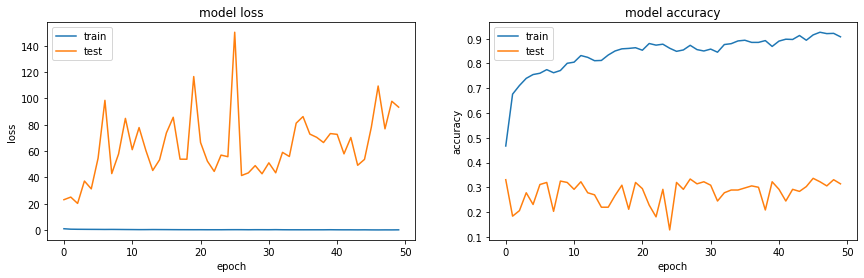

In [77]:
plot_hist(entirely_frozen_incepv3_history, 'entirely_frozen_incepV3')

#### saving the history of the fitting

In [42]:

with open(cwd + '/trainHistoryDict/basic_incepV3_history.p', 'wb') as file_pi:
        pickle.dump(entirely_frozen_incepv3_history.history, file_pi)
print('history saved')

history saved


## Few layers unfrozen

#### loading model

In [0]:
base_incepv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(200, 200, 3),pooling=None)

#### modifying slightly

In [0]:
# add a global spatial average pooling layer
x = base_incepv3.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

#### creating model object

In [0]:
# this is the model we will train
few_unfrozen_incepv3_model = Model(inputs=base_incepv3.input, outputs=predictions)

In [120]:
for layer in base_incepv3.layers:
    print(layer.name)
    layer.trainable = False

input_7
conv2d_564
batch_normalization_564
activation_564
conv2d_565
batch_normalization_565
activation_565
conv2d_566
batch_normalization_566
activation_566
max_pooling2d_24
conv2d_567
batch_normalization_567
activation_567
conv2d_568
batch_normalization_568
activation_568
max_pooling2d_25
conv2d_572
batch_normalization_572
activation_572
conv2d_570
conv2d_573
batch_normalization_570
batch_normalization_573
activation_570
activation_573
average_pooling2d_54
conv2d_569
conv2d_571
conv2d_574
conv2d_575
batch_normalization_569
batch_normalization_571
batch_normalization_574
batch_normalization_575
activation_569
activation_571
activation_574
activation_575
mixed0
conv2d_579
batch_normalization_579
activation_579
conv2d_577
conv2d_580
batch_normalization_577
batch_normalization_580
activation_577
activation_580
average_pooling2d_55
conv2d_576
conv2d_578
conv2d_581
conv2d_582
batch_normalization_576
batch_normalization_578
batch_normalization_581
batch_normalization_582
activation_576
acti

In [121]:
few_unfrozen_incepv3_model.trainable = True
trainable_count = 0

set_trainable = False
for layer in few_unfrozen_incepv3_model.layers:
    if layer.name == 'conv2d_654':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        trainable_count += 1
    else:
        layer.trainable = False

print('percent unfrozen:', trainable_count/ len(few_unfrozen_incepv3_model.layers) * 100 , '%')

percent unfrozen: 10.9717868338558 %


In [122]:
for layer in few_unfrozen_incepv3_model.layers:
    print(layer.name,layer.trainable)

input_7 False
conv2d_564 False
batch_normalization_564 False
activation_564 False
conv2d_565 False
batch_normalization_565 False
activation_565 False
conv2d_566 False
batch_normalization_566 False
activation_566 False
max_pooling2d_24 False
conv2d_567 False
batch_normalization_567 False
activation_567 False
conv2d_568 False
batch_normalization_568 False
activation_568 False
max_pooling2d_25 False
conv2d_572 False
batch_normalization_572 False
activation_572 False
conv2d_570 False
conv2d_573 False
batch_normalization_570 False
batch_normalization_573 False
activation_570 False
activation_573 False
average_pooling2d_54 False
conv2d_569 False
conv2d_571 False
conv2d_574 False
conv2d_575 False
batch_normalization_569 False
batch_normalization_571 False
batch_normalization_574 False
batch_normalization_575 False
activation_569 False
activation_571 False
activation_574 False
activation_575 False
mixed0 False
conv2d_579 False
batch_normalization_579 False
activation_579 False
conv2d_577 False

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)
# compile the model (should be done *after* setting layers to non-trainable)
few_unfrozen_incepv3_model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [124]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)

epochs = 50


model_filepath = 'few_unfrozen_incepv3.h5'
mcp = ModelCheckpoint(model_filepath, monitor='accuracy', save_best_only=True, mode='max')

# Train the model with validation 
few_unfrozen_incepv3_history = few_unfrozen_incepv3_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 20s 825ms/step - loss: 0.7603 - accuracy: 0.6524 - val_loss: 36.0087 - val_accuracy: 0.3833
Epoch 2/50
24/24 [==============================] - 13s 554ms/step - loss: 0.5023 - accuracy: 0.7875 - val_loss: 26.3066 - val_accuracy: 0.4417
Epoch 3/50
24/24 [==============================] - 14s 592ms/step - loss: 0.3423 - accuracy: 0.8590 - val_loss: 86.8298 - val_accuracy: 0.3167
Epoch 4/50
24/24 [==============================] - 13s 552ms/step - loss: 0.2693 - accuracy: 0.8955 - val_loss: 80.3478 - val_accuracy: 0.3222
Epoch 5/50
24/24 [==============================] - 13s 558ms/step - loss: 0.2109 - accuracy: 0.9191 - val_loss: 126.5841 - val_accuracy: 0.3222
Epoch 6/50
24/24 [==============================] - 13s 553ms/step - loss: 0.1218 - accuracy: 0.9535 - val_loss: 67.8172 - val_accuracy: 0.3528
Epoch 7/50
24/24 [==============================] - 13s 547ms/ste

#### testing the model

In [125]:
test_steps = int(len(df_test)/batch_size)

metrics = few_unfrozen_incepv3_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 1s 423ms/step - loss: 223.2455 - accuracy: 0.3722
model accuracy: 0.37222221


#### plotting training

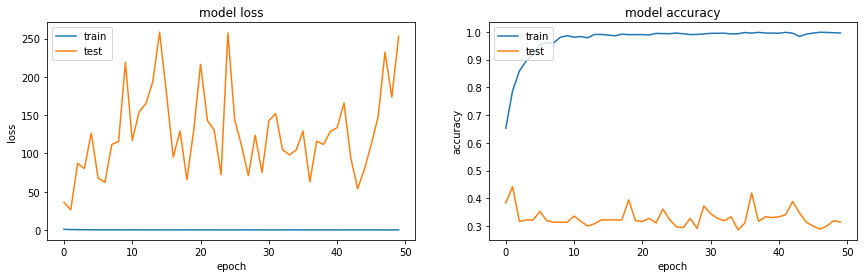

In [126]:
plot_hist(few_unfrozen_incepv3_history, 'few_unfrozen_incepV3')

#### saving the history of the fitting

In [127]:
with open(cwd + '/trainHistoryDict/few_unfrozen_incepv3_history.p', 'wb') as file_pi:
        pickle.dump(few_unfrozen_incepv3_history.history, file_pi)
print('history saved')

history saved


## Many layers unfrozen

#### loading model

In [0]:
base_incepv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(200, 200, 3),pooling=None)

#### modifying slightly

In [0]:
# add a global spatial average pooling layer
x = base_incepv3.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

#### creating model object

In [0]:
# this is the model we will train
many_unfrozen_incepv3_model = Model(inputs=base_incepv3.input, outputs=predictions)

In [96]:
for layer in base_incepv3.layers:
    print(layer.name)
    layer.trainable = False

input_5
conv2d_376
batch_normalization_376
activation_376
conv2d_377
batch_normalization_377
activation_377
conv2d_378
batch_normalization_378
activation_378
max_pooling2d_16
conv2d_379
batch_normalization_379
activation_379
conv2d_380
batch_normalization_380
activation_380
max_pooling2d_17
conv2d_384
batch_normalization_384
activation_384
conv2d_382
conv2d_385
batch_normalization_382
batch_normalization_385
activation_382
activation_385
average_pooling2d_36
conv2d_381
conv2d_383
conv2d_386
conv2d_387
batch_normalization_381
batch_normalization_383
batch_normalization_386
batch_normalization_387
activation_381
activation_383
activation_386
activation_387
mixed0
conv2d_391
batch_normalization_391
activation_391
conv2d_389
conv2d_392
batch_normalization_389
batch_normalization_392
activation_389
activation_392
average_pooling2d_37
conv2d_388
conv2d_390
conv2d_393
conv2d_394
batch_normalization_388
batch_normalization_390
batch_normalization_393
batch_normalization_394
activation_388
acti

In [104]:
many_unfrozen_incepv3_model.trainable = True
trainable_count = 0

set_trainable = False


for layer in many_unfrozen_incepv3_model.layers:
    if layer.name == 'conv2d_381':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        trainable_count += 1
    else:
        layer.trainable = False

print('percent unfrozen:', trainable_count/ len(many_unfrozen_incepv3_model.layers) * 100 , '%')

percent unfrozen: 91.22257053291536 %


In [98]:
for layer in many_unfrozen_incepv3_model.layers:
    print(layer.name,layer.trainable)

input_5 False
conv2d_376 False
batch_normalization_376 False
activation_376 False
conv2d_377 False
batch_normalization_377 False
activation_377 False
conv2d_378 False
batch_normalization_378 False
activation_378 False
max_pooling2d_16 False
conv2d_379 False
batch_normalization_379 False
activation_379 False
conv2d_380 False
batch_normalization_380 False
activation_380 False
max_pooling2d_17 False
conv2d_384 False
batch_normalization_384 False
activation_384 False
conv2d_382 False
conv2d_385 False
batch_normalization_382 False
batch_normalization_385 False
activation_382 False
activation_385 False
average_pooling2d_36 False
conv2d_381 True
conv2d_383 True
conv2d_386 True
conv2d_387 True
batch_normalization_381 True
batch_normalization_383 True
batch_normalization_386 True
batch_normalization_387 True
activation_381 True
activation_383 True
activation_386 True
activation_387 True
mixed0 True
conv2d_391 True
batch_normalization_391 True
activation_391 True
conv2d_389 True
conv2d_392 True


In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)
# compile the model (should be done *after* setting layers to non-trainable)
many_unfrozen_incepv3_model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [100]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)

epochs = 50


model_filepath = 'many_unfrozen_incepv3.h5'
mcp = ModelCheckpoint(model_filepath, monitor='accuracy', save_best_only=True, mode='max')

# Train the model with validation 
many_unfrozen_incepv3_history = many_unfrozen_incepv3_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 29s 1s/step - loss: 0.7465 - accuracy: 0.6438 - val_loss: 349.8679 - val_accuracy: 0.3667
Epoch 2/50
24/24 [==============================] - 19s 806ms/step - loss: 0.5743 - accuracy: 0.7424 - val_loss: 21114.8457 - val_accuracy: 0.3667
Epoch 3/50
24/24 [==============================] - 20s 827ms/step - loss: 0.5034 - accuracy: 0.7788 - val_loss: 3632.6870 - val_accuracy: 0.3667
Epoch 4/50
24/24 [==============================] - 21s 865ms/step - loss: 0.4530 - accuracy: 0.7976 - val_loss: 9801.1680 - val_accuracy: 0.3667
Epoch 5/50
24/24 [==============================] - 20s 828ms/step - loss: 0.3898 - accuracy: 0.8260 - val_loss: 2801.4301 - val_accuracy: 0.3667
Epoch 6/50
24/24 [==============================] - 19s 805ms/step - loss: 0.3587 - accuracy: 0.8361 - val_loss: 257.4725 - val_accuracy: 0.3639
Epoch 7/50
24/24 [==============================] - 16s 65

#### testing the model

In [102]:
test_steps = int(len(df_test)/batch_size)

metrics = many_unfrozen_incepv3_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 1s 426ms/step - loss: 2913.4411 - accuracy: 0.2889
model accuracy: 0.2888889


#### plotting training

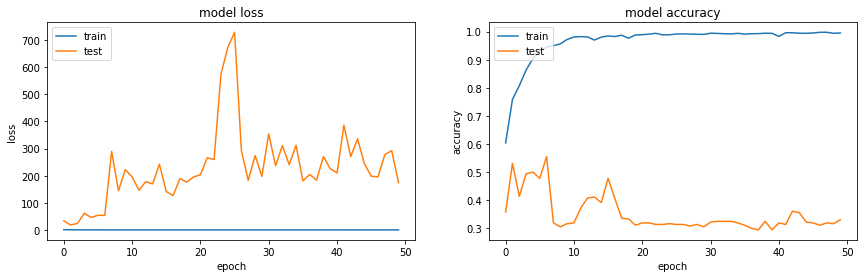

In [0]:
plot_hist(many_unfrozen_incepv3_history, 'many_unfrozen_incepV3')

#### saving the history of the fitting

In [103]:
with open(cwd + '/trainHistoryDict/many_unfrozen_incepv3_history.p', 'wb') as file_pi:
        pickle.dump(many_unfrozen_incepv3_history.history, file_pi)
print('history saved')

history saved


## entirely unfrozen

In [0]:
base_incepv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(200, 200, 3),pooling=None)

#### modifying slightly

In [0]:
# add a global spatial average pooling layer
x = base_incepv3.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

#### creating model object

In [0]:
# this is the model we will train
unfrozen_incepv3_model = Model(inputs=base_incepv3.input, outputs=predictions)

In [131]:
for layer in unfrozen_incepv3_model.layers:
    print(layer.name)
    layer.trainable = True

input_8
conv2d_658
batch_normalization_658
activation_658
conv2d_659
batch_normalization_659
activation_659
conv2d_660
batch_normalization_660
activation_660
max_pooling2d_28
conv2d_661
batch_normalization_661
activation_661
conv2d_662
batch_normalization_662
activation_662
max_pooling2d_29
conv2d_666
batch_normalization_666
activation_666
conv2d_664
conv2d_667
batch_normalization_664
batch_normalization_667
activation_664
activation_667
average_pooling2d_63
conv2d_663
conv2d_665
conv2d_668
conv2d_669
batch_normalization_663
batch_normalization_665
batch_normalization_668
batch_normalization_669
activation_663
activation_665
activation_668
activation_669
mixed0
conv2d_673
batch_normalization_673
activation_673
conv2d_671
conv2d_674
batch_normalization_671
batch_normalization_674
activation_671
activation_674
average_pooling2d_64
conv2d_670
conv2d_672
conv2d_675
conv2d_676
batch_normalization_670
batch_normalization_672
batch_normalization_675
batch_normalization_676
activation_670
acti

In [132]:
for layer in unfrozen_incepv3_model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_8  Trainable = True
conv2d_658  Trainable = True
batch_normalization_658  Trainable = True
activation_658  Trainable = True
conv2d_659  Trainable = True
batch_normalization_659  Trainable = True
activation_659  Trainable = True
conv2d_660  Trainable = True
batch_normalization_660  Trainable = True
activation_660  Trainable = True
max_pooling2d_28  Trainable = True
conv2d_661  Trainable = True
batch_normalization_661  Trainable = True
activation_661  Trainable = True
conv2d_662  Trainable = True
batch_normalization_662  Trainable = True
activation_662  Trainable = True
max_pooling2d_29  Trainable = True
conv2d_666  Trainable = True
batch_normalization_666  Trainable = True
activation_666  Trainable = True
conv2d_664  Trainable = True
conv2d_667  Trainable = True
batch_normalization_664  Trainable = True
batch_normalization_667  Trainable = True
activation_664  Trainable = True
activation_667  Trainable = True
average_pooling2d_63  Trainable = True
conv2d_663  Trainable = True
conv

#### setting the optimizer

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)

# compile the model (should be done *after* setting layers to non-trainable)
unfrozen_incepv3_model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [134]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)

epochs = 50


model_filepath = 'unfrozen_incepv3.h5'
mcp = ModelCheckpoint(model_filepath, monitor='accuracy', save_best_only=True, mode='max')

# Train the model with validation 
unfrozen_incepv3_history = unfrozen_incepv3_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 31s 1s/step - loss: 0.8020 - accuracy: 0.6243 - val_loss: 2348.9036 - val_accuracy: 0.3139
Epoch 2/50
24/24 [==============================] - 21s 880ms/step - loss: 0.5546 - accuracy: 0.7597 - val_loss: 533.1637 - val_accuracy: 0.3667
Epoch 3/50
24/24 [==============================] - 21s 876ms/step - loss: 0.5178 - accuracy: 0.7757 - val_loss: 122.9858 - val_accuracy: 0.3194
Epoch 4/50
24/24 [==============================] - 23s 957ms/step - loss: 0.4518 - accuracy: 0.8128 - val_loss: 7.4244 - val_accuracy: 0.3194
Epoch 5/50
24/24 [==============================] - 18s 733ms/step - loss: 0.4249 - accuracy: 0.8069 - val_loss: 1.9661 - val_accuracy: 0.3194
Epoch 6/50
24/24 [==============================] - 21s 882ms/step - loss: 0.4286 - accuracy: 0.8212 - val_loss: 42.6392 - val_accuracy: 0.3667
Epoch 7/50
24/24 [==============================] - 21s 884ms/step 

#### testing the model

In [136]:
test_steps = int(len(df_test)/batch_size)

metrics = unfrozen_incepv3_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 1s 432ms/step - loss: 1.9472 - accuracy: 0.7111
model accuracy: 0.7111111


#### plotting training

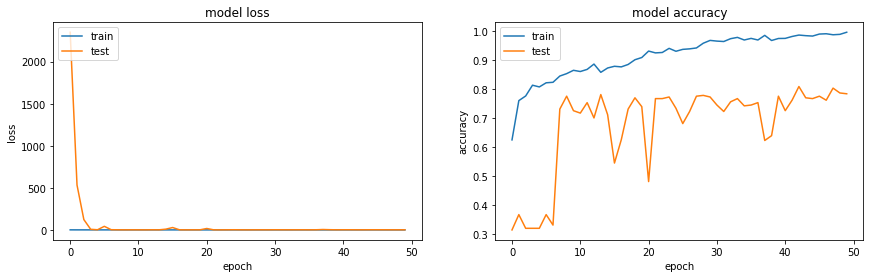

In [135]:
plot_hist(unfrozen_incepv3_history, 'unfrozen_incepV3')

#### saving the history of the fitting

In [138]:
with open(cwd + '/trainHistoryDict/unfrozen_incepv3_history.p', 'wb') as file_pi:
        pickle.dump(unfrozen_incepv3_history.history, file_pi)
print('history saved')

history saved
